In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

idx = pd.IndexSlice
sys.path.append(str(Path.cwd()))

from plotting_constants import colors, min_cost_acceleration_factor

In [2]:
root = Path.cwd().parent.parent.parent / "cluster_data"

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [4]:
mode = "static"
use_breyer = True

assert mode in ["static", "both"]

def get_data(mode, op, breyer=True):

    index_col = [0,1,2]
    header = [0,1,2,3,4,5,6,7,8]

    if not breyer:
        if mode == "chp" or mode == "dh":
            df = pd.read_csv(
                root / f"{mode}_data" / 
                # f"csvs_{op}" / 
                "nodal_capacities.csv", 
                index_col=index_col,
                header=header,
                )

        elif mode == "elec":
            if op == "flex":
                df = pd.read_csv(
                    root / f"elec_data_flex" / "nodal_capacities.csv",
                    index_col=index_col,
                    header=header,
                )
            else:
                df = pd.read_csv(
                    root / f"{mode}_data" / "nodal_capacities.csv",
                    index_col=index_col,
                    header=header,
                )
        df.columns = df.columns.droplevel([0,1,2,3,5,7,8])
    else:
        df = pd.read_csv(
            root /
            "breyer_sweep" /
            "joint_data" /
            "nodal_capacities.csv", 
            index_col=index_col, 
            header=header,
            )
        df = df.loc[:,idx[:,:,:,:,:,mode, op]]# .iloc[:,2:]
        df.columns = df.columns.get_level_values(4)

    df = df.groupby(level=[0,2]).sum()

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier
    df.drop(columns="carrier", inplace=True)

    # df = df.loc["links injection geothermal heat"].loc[idx[:, op]].mul(1e-3)
    df = df.loc["links injection geothermal heat"]
    
    df = df.mul(1e-3)

    if use_breyer:
        # df.index = np.linspace(0, 1, len(df))
        df.index = df.index.to_numpy().astype(int) + min_cost_acceleration_factor

    return df

In [5]:
elec_static = get_data("elec", "static")
chp_static = get_data("chp", "static")
dh_static = get_data("dh", "static")

if mode == "both":
    elec_flex = get_data("elec", "flex")
    chp_flex = get_data("chp", "flex")
    dh_flex = get_data("dh", "flex")

In [6]:
cost_data = pd.read_csv(
    Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data" / "costs.csv",
    index_col=[0,1,2],
    header=[4,5,6,7,8],
    ).sum()

-----------------------------------------------
elec
2020    8.545950e+11
2025    8.546533e+11
2030    8.546730e+11
2035    8.524069e+11
2040    8.387423e+11
dtype: float64
-----------------------------------------------
chp
2020    8.535487e+11
2025    8.498791e+11
2030    8.450774e+11
2035    8.388875e+11
2040    8.330904e+11
dtype: float64
-----------------------------------------------
dh
2020    8.532368e+11
2025    8.495557e+11
2030    8.454517e+11
2035    8.404916e+11
2040    8.364544e+11
dtype: float64
[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]
[2015. 2020. 2025. 2030. 2035. 2040. 2045. 2050. 2055.]


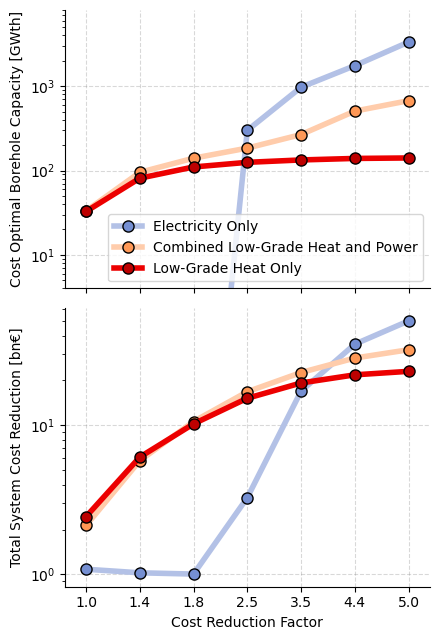

In [7]:
from matplotlib.patches import Patch

if mode == "static":
    figsize = (10, 3.5)
elif mode == "both":
    figsize = (13, 4.5)

include_regions = False

# fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={"width_ratios": [1, 2]})
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig, axs = plt.subplots(2, 1, figsize=(4.5, 6.5))

# elec_static.plot.(ax=ax, stacked=True, width=0.8, edgecolor='black', linewidth=0.5)

labels = {
    "elec static": "Electricity Only",
    "chp static": "Combined Low-Grade Heat and Power",
    "dh static": "Low-Grade Heat Only",
}

line_kwargs = {
    "marker": 'o',
    "markersize": 8,
    "linewidth": 4.,
    "markeredgewidth": 1,
    "markeredgecolor": "k",
}

if mode == "both":
    line_kwargs.update({
        # "markersize": 5,
        "markersize": None,
        "marker": None,
        "linewidth": 3,
        "markeredgewidth": 0.5,
    })

if use_breyer: x_type = float
else: x_type = int

def plot_capacity_to_ax(ax):

    ax.plot(
        # elec_static.index.astype(x_type)[2:],
        # elec_static.values[2:],
        elec_static.index.astype(x_type),
        elec_static.values,
        color=colors["elec"],
        label=labels["elec static"],
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        **line_kwargs
        )
    ax.plot(
        # chp_static.index.astype(x_type)[2:],
        # chp_static.values[2:],
        chp_static.index.astype(x_type),
        chp_static.values,
        color=colors["chp"],
        label=labels["chp static"],
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
        **line_kwargs)

    ax.plot(
        # dh_static.index.astype(x_type)[2:],
        # dh_static.values[2:],
        dh_static.index.astype(x_type),
        dh_static.values,
        color=colors["dh"],
        label=labels["dh static"],
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
        **line_kwargs)


def plot_cost_to_ax(ax):

    max_cost = cost_data.max()

    for mode in ["elec", "chp", "dh"]:

        color = colors[mode]

        plot_data = cost_data.loc[idx[:,mode,"static"]]

        plot_data.index = (
            plot_data
            .index
            .get_level_values(0)
            .astype(int)
            .to_numpy() +
            min_cost_acceleration_factor
        )

        # plot_data.iloc[3:].sub(max_cost).abs().mul(1e-9).add(1.).plot(
        plot_data.sub(max_cost).abs().mul(1e-9).add(1.).plot(
            ax=ax,
            color=color,
            marker="o",
            markersize=8.,
            linewidth=4.,
            markeredgewidth=1,
            markeredgecolor="k",
            markerfacecolor=adjust_lightness(color, 0.8),
        )

        print('-----------------------------------------------')

        print(mode)
        perc_reduction = plot_data.div(max_cost)
        print()

        print('===============================================')

plot_capacity_to_ax(axs[0])
plot_cost_to_ax(axs[1])

handles = []
labels = []

labels.append("Electricity Only")
handles.append(
    Line2D(
        [0], [0], color=colors["elec"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        ))

labels.append("Combined Low-Grade Heat and Power")
handles.append(
    Line2D(
        [0], [0], color=colors["chp"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
    ))
    
labels.append("Low-Grade Heat Only")
handles.append(
    Line2D(
        [0], [0], color=colors["dh"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
    ))

if include_regions:
    handles.append(Patch(facecolor='seagreen', alpha=0.2))
    handles.append(Patch(facecolor='darkmagenta', alpha=0.2))
    labels.append("Current Cost Estimate")
    labels.append("2050 Cost Estimate")

if mode == "both":
    handles = (
        handles[0] + [
        Line2D([0], [0], color='white', lw=0, label=''),
        Line2D([0], [0], color='k', lw=1.5, label='Standard Operation'),
        Line2D([0], [0], color='k', lw=1.5, linestyle="--", label='Flexible Operation'),
        ]
    )


axs[0].set_xticklabels([])
axs[0].legend(handles=handles, labels=labels, loc="lower right") 

for ax in axs:
    ax.set_yscale("log")
    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axs[0].set_ylabel("Cost Optimal Borehole Capacity [GWth]")
axs[1].set_ylabel(r"Total System Cost Reduction [bn€]")
axs[1].set_xlabel("Cost Reduction Factor")

if include_regions:
    ax.fill_between(
        [0.15, 0.25],
        [0, 0],
        [1e4, 1e4],
        alpha=0.2,
        color="seagreen",
    )
    ax.fill_between(
        [0.9, 1.],
        [0, 0],
        [1e4, 1e4],
        alpha=0.2,
        color="darkmagenta",
    )

axs[0].set_ylim(4, 8e3)
axs[0].set_xlim(2018, 2052)
axs[1].set_xlim(2018, 2052)

print(axs[1].get_xticklabels())
print(axs[1].get_xticks())

axs[1].set_xticks(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    ['1.0', '1.4', '1.8', '2.5', '3.5', '4.4', '5.0']
    )

plt.tight_layout()
# plt.savefig("main_plot.pdf")

plt.show()

In [24]:
current = 15

factors = np.array([1., 1.4, 1.8, 2.5, 3.5, 4.4, 5.])

# maxes = np.max([elec_static.values, chp_static.values, dh_static.values], axis=0)
maxes = elec_static.values + chp_static.values

In [21]:
def get_lr(cap0, new_cap, new_fac):
    return 1 - 2**(- np.log(1 / new_fac) / np.log(new_cap / cap0))

0.2 0.2
0.25 0.36
0.21 0.17
0.21 0.22
0.22 0.23
0.21 0.14


C:\Users\lukas\AppData\Local\Temp\ipykernel_35684\2812281541.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['10', '15', '20', '25', '30'])


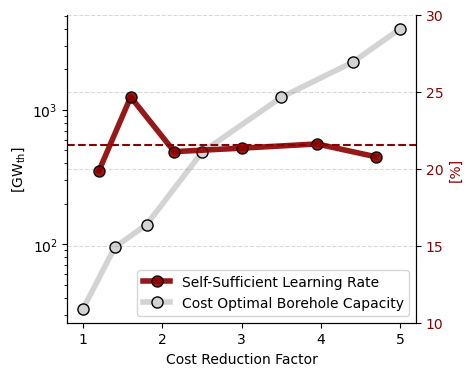

In [93]:
from matplotlib.ticker import LinearLocator


fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

line_kwargs = dict(
    markersize=8,
    linewidth=4,
    markeredgewidth=1,
)

ax.plot(
    factors,
    maxes,
    color="lightgrey",
    marker="o",
    label="Cost Optimal Borehole Capacity",
    markeredgecolor="k",
    **line_kwargs,
    )


learning_rates = [0.05, 0.075, 0.1]

outside_europe_factor = 1 # assume only 1/factor of EGS capacity is built in Europe

# for lr in learning_rates:
local_lrs, global_lrs = [], []

for old_cap, new_cap, old_fac, new_fac in zip(maxes, maxes[1:], factors, factors[1:]):

    new_cap *= outside_europe_factor

    b = np.log(1 / new_fac) / np.log(new_cap / maxes[0])
    lr = 1 - 2**b

    global_lrs.append(lr)

    local_b = np.log(old_fac / new_fac) / np.log(new_cap / old_cap)
    local_lr = 1 - 2**local_b

    print(round(lr, 2), round(local_lr, 2))

    local_lrs.append(local_lr)

ax2 = ax.twinx()

ax2.plot(
    # factors[1:],
    pd.Series(factors).rolling(2).mean().dropna().values,
    global_lrs,
    color="darkred",
    marker="o",
    label="Self-Sufficient Learning Rate",
    alpha=0.9,
    markeredgecolor="k",
    **line_kwargs,
    )
ax2.axhline(np.mean(global_lrs), color="darkred", linestyle="--")

'''
ax2.plot(
    # factors[1:],
    pd.Series(factors).rolling(2).mean().dropna().values,
    local_lrs,
    color="darkred",
    marker="x",
    label="Local Learning Rate",
    **line_kwargs,
    )
'''

ax2.set_ylim(0.1, 0.3)

ax2.grid(True, linestyle="--", color="grey", alpha=0.3)
# ax2.set_ylabel('Learning Rate [%]', color='darkred')
ax2.set_ylabel('[%]', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax2.yaxis.set_major_locator(LinearLocator(numticks=5))
ax2.set_yticklabels(['10', '15', '20', '25', '30'])

ax.set_ylabel(r'[GW$\mathregular{_{th}}$]')

# ax.legend()
handles, labels = ax2.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='lightgrey', lw=4, marker='o', markersize=8, markeredgewidth=1, markeredgecolor='k'))
labels.append('Cost Optimal Borehole Capacity')


ax2.legend(handles=handles, labels=labels, loc="lower right")

ax.set_xlabel("Cost Reduction Factor")

ax.set_yscale("log")

ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

plt.savefig("learning_rate.pdf")
plt.show()